## ЦЕЛЬ:
Исследовать поведение пользователей в обновлённом приложении.

## Гипотезы:
1) Существует разница в поведении групп, которые проходят и не проходят обучение.
2) Повторное прохождение обучения положительно влияет на оплату.
3) Если пользователь сначала выбирает сложность обучения, то обучение он после этого не проходит.

## ЗАДАЧИ:
1) Определить, насколько обучение сокращает время прохождения этапов игры.
2) Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3) Определить, насколько прозрачен процесс взаимодействия с игрой.

In [1]:
# получение данных
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
events = pd.read_csv ('P3_Events.csv')
purchase = pd.read_csv ('P3_Purchase.csv')

## Преобразование и фильтрация данных для дальнейшего анализа

In [2]:
# Перевод данных в datatime
purchase['event_datetime'] = pd.to_datetime(purchase['event_datetime'],format='%Y-%m-%dT%H:%M:%S',errors='coerce')
events['start_time'] = pd.to_datetime(events['start_time'],format='%Y-%m-%dT%H:%M:%S',errors='coerce')

In [3]:
# Маска для фильтрации пользователей, зарегистрировавшихся в 2018 году
mask = (events['start_time'].dt.year == 2018) & (events.event_type == 'registration')

In [4]:
# Список id пользователей, зарегистрировавшихся в 2018 году
reglist = events[mask]['user_id'].to_list()

In [5]:
# Фильтрация таблицы с событиями по пользователям, зарегистрировавшимся в 2018 году 
FiltredEvents = events[events['user_id'].isin(reglist)]
# Переименование названия столбца для дальнейшего объединения
FiltredEvents = FiltredEvents.rename(columns={"id": "event_id"})

In [6]:
# Фильтрация таблицы с покупками по пользователям, зарегистрировавшимся в 2018 году
FiltredPurchase = purchase[purchase['user_id'].isin(reglist)].copy()
# Добавление типа события
FiltredPurchase['event_type'] = 'purchase'
# Переименование названия столбцов для дальнейшего объединения
FiltredPurchase = FiltredPurchase.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})

In [7]:
# Объединение таблиц с событиями и покупками
TotalEvents = pd.concat([FiltredEvents,FiltredPurchase],sort=False)
TotalEvents = TotalEvents.reset_index(drop=True).sort_values('start_time')

## Проверка гипотезы 1. О том, что существует разница в поведении групп, которые проходят и не проходят обучение.
Сравнение времени прохождения этапов игры для пользователей, которые завершили обучение, и пользователей, не начинавших обучение.

Начнем с анализа времени на прохождение этапов игры пользователями, завершившими обучение

In [8]:
# создаем маску для фильтрации пользователей по критерию завершения обучения
mask2 = (TotalEvents.event_type == 'tutorial_finish')
# создаем список id пользователей, завершивших обучение
tutorial_finish_list = TotalEvents[mask2]['user_id'].to_list()
# создаем таблицу с действиями пользователей, завершивших обучение
FinishedTutorialEvents = TotalEvents[TotalEvents['user_id'].isin(tutorial_finish_list)]

In [9]:
# уточняем количество пользователей, завершивших обучение
print(FinishedTutorialEvents.user_id.nunique(), 'пользователей завершили обучение')

10250 пользователей завершили обучение


Мы знаем, что пользователь может начать и закончить обучение несколько раз, но для проверки первой гипотезы данный факт мы опустим, беря в учет только минимальные значения времени начала и окончания обучения каждого пользователя

In [10]:
# создаем сводную таблицу, в которой отображается минимальное время каждого этапа для конкретного пользователя
FinishedTutorial_pivot = FinishedTutorialEvents.pivot_table(
    values = 'start_time',
    index = 'user_id',
    columns = 'event_type',
    aggfunc = 'min'
)
# проверяем как выглядит сводная
FinishedTutorial_pivot.head()

event_type,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
user_id,,,,,,
27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40
27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11
27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51
27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40
27839,2018-01-01 22:37:50,2018-01-01 22:42:54,NaT,2018-01-01 18:24:01,2018-01-01 19:16:32,2018-01-01 19:11:36


In [11]:
# добавляем столбцы со временем прохождения этапов
FinishedTutorial_pivot['delta1'] = FinishedTutorial_pivot.tutorial_start - FinishedTutorial_pivot.registration
FinishedTutorial_pivot['delta2'] = FinishedTutorial_pivot.tutorial_finish - FinishedTutorial_pivot.tutorial_start
FinishedTutorial_pivot['delta3'] = FinishedTutorial_pivot.level_choice - FinishedTutorial_pivot.tutorial_finish
FinishedTutorial_pivot['delta4'] = FinishedTutorial_pivot.pack_choice - FinishedTutorial_pivot.level_choice
FinishedTutorial_pivot['delta5'] = FinishedTutorial_pivot.purchase - FinishedTutorial_pivot.pack_choice
FinishedTutorial_pivot['delta6'] = FinishedTutorial_pivot.purchase - FinishedTutorial_pivot.registration

In [12]:
# создаем таблицу с корректным порядком столбцов 
FinishedTutorial_sorted = FinishedTutorial_pivot[[
    'registration', 'delta1', 'tutorial_start', 'delta2', 'tutorial_finish', 'delta3',
    'level_choice', 'delta4', 'pack_choice', 'delta5', 'purchase', 'delta6'
]].copy()
# добавляем столбец-определитель группы пользователей для работы с данными таблицы после дальнейшего объединения
FinishedTutorial_sorted['group'] = 'Прошедшие обучение'
FinishedTutorial_sorted.head()

event_type,registration,delta1,tutorial_start,delta2,tutorial_finish,delta3,level_choice,delta4,pack_choice,delta5,purchase,delta6,group
user_id,,,,,,,,,,,,,
27833,2018-01-01 04:07:25,0 days 13:40:15,2018-01-01 17:47:40,0 days 00:02:28,2018-01-01 17:50:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,Прошедшие обучение
27834,2018-01-01 08:35:10,0 days 11:11:01,2018-01-01 19:46:11,0 days 00:01:50,2018-01-01 19:48:01,NaT,NaT,NaT,NaT,NaT,NaT,NaT,Прошедшие обучение
27835,2018-01-01 11:54:47,0 days 03:06:04,2018-01-01 15:00:51,0 days 00:05:24,2018-01-01 15:06:15,0 days 05:31:07,2018-01-01 20:37:22,0 days 00:01:21,2018-01-01 20:38:43,NaT,NaT,NaT,Прошедшие обучение
27836,2018-01-01 13:28:07,0 days 01:26:33,2018-01-01 14:54:40,0 days 00:48:18,2018-01-01 15:42:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,Прошедшие обучение
27839,2018-01-01 18:24:01,0 days 00:47:35,2018-01-01 19:11:36,0 days 00:04:56,2018-01-01 19:16:32,0 days 03:21:18,2018-01-01 22:37:50,0 days 00:05:04,2018-01-01 22:42:54,NaT,NaT,NaT,Прошедшие обучение


In [13]:
# высчитываем средние показатели времени прохождения этапов
print('Среднее время от регистрации пользователя до начала обучения составляет', FinishedTutorial_sorted.delta1.mean())
print('Среднее время от начала обучения до его завершения составляет', FinishedTutorial_sorted.delta2.mean())
print('Среднее время от завершения обучения до выбора пользователем уровня сложности составляет', FinishedTutorial_sorted.delta3.mean())
print('Среднее время от выбора пользователем уровня сложности до выбора пакета вопросов', FinishedTutorial_sorted.delta4.mean())
print('Среднее время от выбора пользователем пакета вопросов до покупки платного пакета вопросов', FinishedTutorial_sorted.delta5.mean())
print('Среднее время на прохождение всех этапов пользователем составляет', FinishedTutorial_sorted.delta6.mean())
print('Среднее время на прохождение каждого этапа пользователем составляет', 
      ((FinishedTutorial_sorted.delta1 + FinishedTutorial_sorted.delta2 + FinishedTutorial_sorted.delta3 + FinishedTutorial_sorted.delta4
       +FinishedTutorial_sorted.delta5)/5).mean())

Среднее время от регистрации пользователя до начала обучения составляет 0 days 04:31:04.938146341
Среднее время от начала обучения до его завершения составляет 0 days 00:12:13.823121951
Среднее время от завершения обучения до выбора пользователем уровня сложности составляет 0 days 02:19:46.959472070
Среднее время от выбора пользователем уровня сложности до выбора пакета вопросов 0 days 00:05:18.146058732
Среднее время от выбора пользователем пакета вопросов до покупки платного пакета вопросов 3 days 17:17:59.641326883
Среднее время на прохождение всех этапов пользователем составляет 4 days 00:30:03.247408431
Среднее время на прохождение каждого этапа пользователем составляет 0 days 19:18:00.649481686


Далее анализируем время прохождения этапов пользователями, никогда не начинавшими обучение

In [14]:
# создаем маску для фильтрации пользователей по критерию начала обучения
mask3 = (TotalEvents.event_type == 'tutorial_start')
# создаем список id пользователей, начинавших обучение
tutorial_start_list = TotalEvents[mask3]['user_id'].to_list()
# создаем таблицу с действиями пользователей, никогда не начинавших обучение
NoStartTutorialEvents = TotalEvents[~TotalEvents['user_id'].isin(tutorial_start_list)]

In [15]:
# уточняем количество пользователей, завершивших обучение
print(NoStartTutorialEvents.user_id.nunique(), 'пользователей никогда не начинали обучение')

8068 пользователей никогда не начинали обучение


Мы знаем, что пользователь может начать и закончить обучение несколько раз, но для проверки первой гипотезы данный факт мы опустим, беря в учет только минимальные значения времени начала и окончания обучения каждого пользователя

In [16]:
# создаем сводную таблицу, в которой отображается минимальное время каждого этапа для конкретного пользователя
NoStartTutorial_pivot = NoStartTutorialEvents.pivot_table(
    values = 'start_time',
    index = 'user_id',
    columns = 'event_type',
    aggfunc = 'min'
)
# проверяем как выглядит сводная
NoStartTutorial_pivot.head()

event_type,level_choice,pack_choice,purchase,registration
user_id,,,,
27832,NaT,NaT,NaT,2018-01-01 03:48:40
27837,NaT,NaT,NaT,2018-01-01 14:08:40
27838,NaT,NaT,NaT,2018-01-01 14:42:58
27844,NaT,NaT,NaT,2018-01-02 00:13:22
27848,NaT,NaT,NaT,2018-01-02 06:05:02


In [17]:
# добавляем столбцы со временем прохождения этапов
NoStartTutorial_pivot['delta1'] = NoStartTutorial_pivot.level_choice - NoStartTutorial_pivot.registration
NoStartTutorial_pivot['delta4'] = NoStartTutorial_pivot.pack_choice - NoStartTutorial_pivot.level_choice
NoStartTutorial_pivot['delta5'] = NoStartTutorial_pivot.purchase - NoStartTutorial_pivot.pack_choice
NoStartTutorial_pivot['delta6'] = NoStartTutorial_pivot.purchase - NoStartTutorial_pivot.registration

In [18]:
# создаем таблицу с корректным порядком столбцов
NoStartTutorial_sorted = NoStartTutorial_pivot[[
    'registration', 'delta1', 'level_choice', 'delta4', 'pack_choice', 'delta5', 'purchase', 'delta6'
]].copy()
# добавляем столбец-определитель группы пользователей для работы с данными таблицы после дальнейшего объединения
NoStartTutorial_sorted['group'] = 'Не начинавшие обучение'
NoStartTutorial_sorted.head()

event_type,registration,delta1,level_choice,delta4,pack_choice,delta5,purchase,delta6,group
user_id,,,,,,,,,
27832,2018-01-01 03:48:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,Не начинавшие обучение
27837,2018-01-01 14:08:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,Не начинавшие обучение
27838,2018-01-01 14:42:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,Не начинавшие обучение
27844,2018-01-02 00:13:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,Не начинавшие обучение
27848,2018-01-02 06:05:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,Не начинавшие обучение


In [19]:
# высчитываем средние показатели времени прохождения этапов
print('Среднее время от регистрации пользователя до выбора пользователем уровня сложности составляет', NoStartTutorial_sorted.delta1.mean())
print('Среднее время от выбора пользователем уровня сложности до выбора пакета вопросов', NoStartTutorial_sorted.delta4.mean())
print('Среднее время от выбора пользователем пакета вопросов до покупки платного пакета вопросов', NoStartTutorial_sorted.delta5.mean())
print('Среднее время на прохождение всех этапов пользователем составляет', 
      (NoStartTutorial_sorted.purchase-NoStartTutorial_sorted.registration).mean())
print('Среднее время на прохождение каждого этапа пользователем составляет', 
      ((NoStartTutorial_sorted.delta1 + NoStartTutorial_sorted.delta4 + NoStartTutorial_sorted.delta5)/3).mean())

Среднее время от регистрации пользователя до выбора пользователем уровня сложности составляет 0 days 05:15:33.122448979
Среднее время от выбора пользователем уровня сложности до выбора пакета вопросов 0 days 00:05:23.824324324
Среднее время от выбора пользователем пакета вопросов до покупки платного пакета вопросов 4 days 04:49:33.590909090
Среднее время на прохождение всех этапов пользователем составляет 4 days 09:06:01.909090909
Среднее время на прохождение каждого этапа пользователем составляет 1 days 11:02:00.636363636


In [20]:
# вычисляем различие между временем прохождения этапов для групп пользователей, проходивших и не проходивших обучение
print('В среднем пользователи, завершившие обучение, переходят от регистрации до начала обучения', 
      (NoStartTutorial_sorted.delta1.mean()-FinishedTutorial_sorted.delta1.mean()), 'быстрее, чем пользователи, не начинавшие обучение '
      'переходят от регистрации до выбора уровня сложности')
print('В среднем пользователи, завершившие обучение, переходят от выбора уровня сложности до выбора пакетов на', 
      (NoStartTutorial_sorted.delta4.mean()-FinishedTutorial_sorted.delta4.mean()), 'быстрее пользователей, не начинавших обучение')
print('В среднем пользователи, завершившие обучение, переходят от выбора пакетов до покупки пакетов на', 
      (NoStartTutorial_sorted.delta5.mean()-FinishedTutorial_sorted.delta5.mean()), 'быстрее пользователей, не начинавших обучение')
print('В среднем пользователи, завершившие обучение, тратят на прохождение всех этапов на', 
      (NoStartTutorial_sorted.delta6.mean()- FinishedTutorial_sorted.delta6.mean()), 'меньше пользователей, никогда обучение не проходивших')

В среднем пользователи, завершившие обучение, переходят от регистрации до начала обучения 0 days 00:44:28.184302638 быстрее, чем пользователи, не начинавшие обучение переходят от регистрации до выбора уровня сложности
В среднем пользователи, завершившие обучение, переходят от выбора уровня сложности до выбора пакетов на 0 days 00:00:05.678265592 быстрее пользователей, не начинавших обучение
В среднем пользователи, завершившие обучение, переходят от выбора пакетов до покупки пакетов на 0 days 11:31:33.949582207 быстрее пользователей, не начинавших обучение
В среднем пользователи, завершившие обучение, тратят на прохождение всех этапов на 0 days 08:35:58.661682478 меньше пользователей, никогда обучение не проходивших


Для удобства визуализации, соединим две таблицы и проводим дальнейшую обработку

In [21]:
TotaldeltaEvents = pd.concat([FinishedTutorial_sorted, NoStartTutorial_sorted],sort=False)
TotaldeltaEvents = TotaldeltaEvents.reset_index(drop=True).sort_values('registration')
TotaldeltaEvents.delta1 = TotaldeltaEvents.delta1/pd.Timedelta('1 hour')
TotaldeltaEvents.delta4 = TotaldeltaEvents.delta4/pd.Timedelta('1 hour')
TotaldeltaEvents.delta5 = TotaldeltaEvents.delta5/pd.Timedelta('1 hour')
TotaldeltaEvents.delta6 = TotaldeltaEvents.delta6/pd.Timedelta('1 hour')

## Строим визуализацию

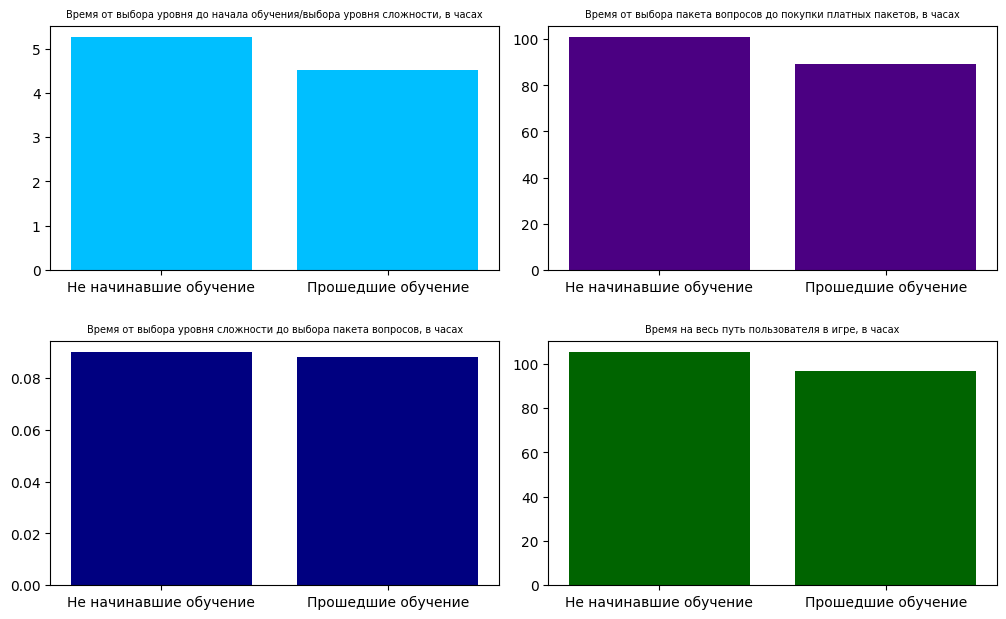

In [22]:
# построим визуализацию сравнительных данных
grouped_delta = TotaldeltaEvents.groupby(['group'])[['delta1','delta4','delta5', 'delta6']].mean()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
fig = plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.0)
# столбчатая диаграмма со временем прохождения 1 этапа
axes[0,0].bar(x=grouped_delta.index, 
    height=grouped_delta.delta1,
    color='deepskyblue'
)
axes[0,0].set_title('Время от выбора уровня до начала обучения/выбора уровня сложности, в часах', fontsize = 7);
# столбчатая диаграмма со временем прохождения 4 этапа
axes[1,0].bar(x=grouped_delta.index, 
    height=grouped_delta.delta4,
    color='navy'
)
axes[1,0].set_title('Время от выбора уровня сложности до выбора пакета вопросов, в часах', fontsize = 7);
# столбчатая диаграмма со временем прохождения 5 этапа
axes[0,1].bar(x=grouped_delta.index, 
    height=grouped_delta.delta5,
    color='indigo'
)
axes[0,1].set_title('Время от выбора пакета вопросов до покупки платных пакетов, в часах', fontsize = 7);
# столбчатая диаграмма со временем прохождения всего пути
axes[1,1].bar(x=grouped_delta.index, 
    height=grouped_delta.delta6,
    color='darkgreen'
)
axes[1,1].set_title('Время на весь путь пользователя в игре, в часах', fontsize = 7);


## Вывод:
Гипотеза №1 верна, разница в поведении групп, которые проходят обучение и не проходят существует. 
1) Этап от регистрации до начала обучения в группе, которая завершила обучение, равный этапу от регистрации до выбора уровня сложности в группе, никогда
не проходившей обучение, в группе, которая завершила обучение, длится в среднем на 44 минуты меньше.
2) Этап от выбора уровня сложности, до выбора бесплатных пакетов в группе, завершившей обучение, длится в среднем на 5 секунд меньше.
3) Этап от выбора бесплатных пакетов до покупки платных в группе, завершившей обучение, длится в среднем на 11 часов 30 минут меньше.
4) В среднем, группа пользователей, завершивших обучение, тратит на прохождение всех этапов на 8 часов 35 минут меньше, чем группа пользователей, никогда не проходивших обучение.

## Проверка гипотезы 2. О влиянии повторного прохождения обучения на оплату.
Рассмотрим влияение количества попыток начала обучения на покупку платных пакетов.

In [23]:
# создаем сводную таблицу по количеству совершенных каждым пользователем действий,
# на основании таблицы с действиями пользователей, зарегистрировавшихся в 2018 году
UserActions = TotalEvents.pivot_table(
    values= 'start_time',
    index= 'user_id',
    columns= 'event_type',
    aggfunc= 'count'
).fillna(0)

In [24]:
# для расчета выручки с каждой группы сгруппируем таблицу по затратам каждого пользователя
revenue_by_users = TotalEvents.groupby('user_id')['amount'].sum()
# добавим столбец с затратами по каждому пользователю в сводную
UserActions_with_revenue = UserActions.merge(revenue_by_users, on = 'user_id')

In [25]:
# строим сводную таблицу с количеством оплат пакетов пользователей, сгруппированных по количеству попыток начала обучения
purchase_by_group = UserActions[['tutorial_start', 'purchase']].pivot_table(
    values= 'purchase',
    index= 'tutorial_start',
    aggfunc= 'sum',
)
# строим сводную таблицу с количеством регистраций пользователей, сгруппированных по количеству попыток начала обучения, для получения их численности
registration_by_group = UserActions[['tutorial_start', 'registration']].pivot_table(
    values= 'registration',
    index= 'tutorial_start',
    aggfunc= 'count',
)
# строим сводную таблицу с выручкой от пользователей, сгруппированных по количеству попыток начала обучения
revenue_by_group = UserActions_with_revenue[['tutorial_start', 'amount']].pivot_table(
    values= 'amount',
    index= 'tutorial_start',
    aggfunc= 'mean',
)
# строим сводную таблицу с выручкой от пользователей, сгруппированных по количеству попыток начала обучения
sum_revenue_by_group = UserActions_with_revenue[['tutorial_start', 'amount']].pivot_table(
    values= 'amount',
    index= 'tutorial_start',
    aggfunc= 'sum',
)
# переименовываем столбец - показателя средней выручки с группы пользователей
revenue_by_group = revenue_by_group.rename(columns = {'amount':'mean_amount'})
sum_revenue_by_group = sum_revenue_by_group.rename(columns = {'amount':'sum_amount'})
# объединяем таблицы
purchase_and_registration_by_group = purchase_by_group.merge(registration_by_group, on = 'tutorial_start')
purchase_amount_and_registration_by_group = purchase_and_registration_by_group.merge(revenue_by_group, on = 'tutorial_start')
purchase_amount2_and_registration_by_group = purchase_amount_and_registration_by_group.merge(sum_revenue_by_group, on = 'tutorial_start')
# добавляем столбец с конверсией поведения пользователей
purchase_amount2_and_registration_by_group['conversion_rate'] = (purchase_and_registration_by_group.purchase/
                                                                purchase_and_registration_by_group.registration)*100
display(purchase_amount2_and_registration_by_group)

,purchase,registration,mean_amount,sum_amount,conversion_rate
tutorial_start,,,,,
0.0,22.0,8068,0.350149,2825.0,0.272682
1.0,1207.0,9103,14.552895,132475.0,13.259365
2.0,218.0,1589,15.701699,24950.0,13.719320
3.0,51.0,427,13.290398,5675.0,11.943794
4.0,30.0,221,13.348416,2950.0,13.574661
5.0,16.0,109,17.889908,1950.0,14.678899
6.0,14.0,116,14.439655,1675.0,12.068966
7.0,12.0,94,14.095745,1325.0,12.765957
8.0,13.0,86,15.697674,1350.0,15.116279


## Строим визуализации

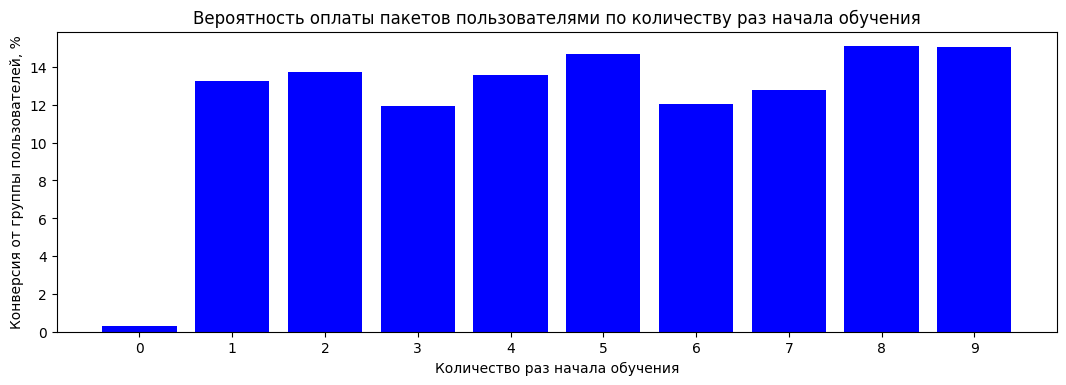

In [26]:
#визуализация графика
fig = plt.figure(figsize=(10, 3))
axes = fig.add_axes([0, 0, 1, 1])
# столбчатая диаграмма с вероятностью покупки платных пакетов пользователями по группам
axes.bar(x=purchase_amount2_and_registration_by_group.index, 
    height=purchase_amount2_and_registration_by_group.conversion_rate,
    color='blue'
)
axes.set_xticks(purchase_amount2_and_registration_by_group.index)
axes.set_title('Вероятность оплаты пакетов пользователями по количеству раз начала обучения', fontsize = 12)
axes.set_xlabel('Количество раз начала обучения')
axes.set_ylabel('Конверсия от группы пользователей, %');

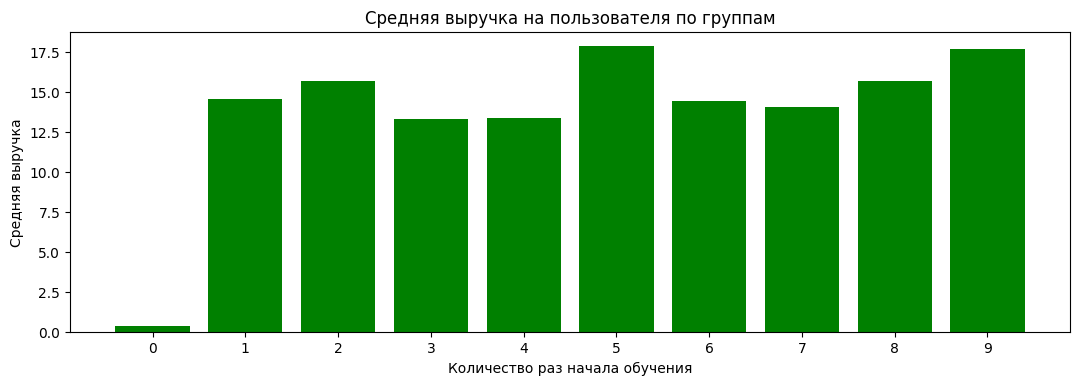

In [27]:
#визуализация графика
fig = plt.figure(figsize=(10, 3))
axes = fig.add_axes([0, 0, 1, 1])
# столбчатая диаграмма со средним чеком на пользователя по группам
axes.bar(x=purchase_amount2_and_registration_by_group.index, 
    height=purchase_amount2_and_registration_by_group.mean_amount,
    color='green'
)
axes.set_xticks(purchase_amount2_and_registration_by_group.index)
axes.set_title('Средняя выручка на пользователя по группам', fontsize = 12)
axes.set_xlabel('Количество раз начала обучения')
axes.set_ylabel('Средняя выручка');

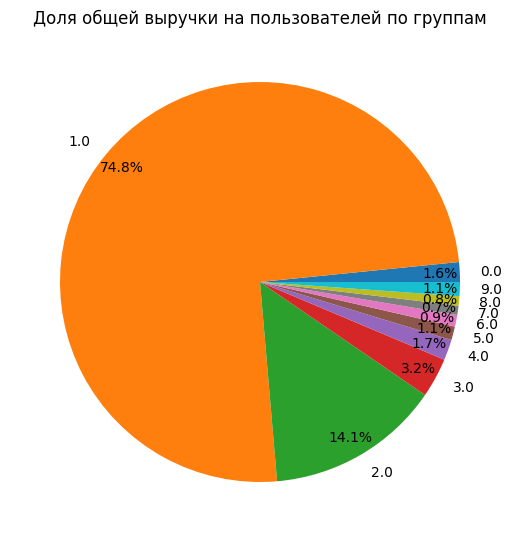

In [28]:
#визуализация графика
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
# визуализация графика о соотношении общей выручки с разных групп пользователей
axes.pie(
    x = purchase_amount2_and_registration_by_group.sum_amount,
    labels=purchase_amount2_and_registration_by_group.index,
    autopct='%.1f%%',
    explode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    pctdistance = 0.9
)
axes.set_title('Доля общей выручки на пользователей по группам', fontsize = 12);

## Вывод:
Гипотеза №2 верна, прохождение обучения положительно влияет на вероятность оплаты. 
1) Самая низкая конверсия наблюдается у группы пользователей, которые вообще не начинали обучение. Возможно, это указывает на низкую замотивированность и вовлеченность данной группы пользователей.
2) Самая высокая конверсия у групп пользователей, которые начинали обучение 8 и 9 раз. Скорее всего это связано с их высокой заинтересованностью игрой.
3) В целом конверсия пользователей, начинавших обучение хотя бы раз колеблется в пределах 12-15% 
4) Средняя выручка с пользователей групп, проходивших обучение существенно выше выручки пользователей, обучение не проходивших. При этом не выявляется корреляции между количеством попыток начала обучения и средней выручкой между разными группами пользователей, проходивших обучение. 
5) В общем, более 74% общей выручки приходится на группу, начинавшую обучение 1 раз. В первую очередь это связано с тем, что она более многочисленная.

## Проверка гипотезы 3. О возможности прохождения обучения пользователями, первоначально пропустившими этот этап игры.
Оценка вероятности начала обучения пользователем, который вместо прохождения обучения сразу перешел к выбору уровня сложности.

In [29]:
# создаем таблицу со временем выбора уровня каждого пользователя
choosing_level = TotalEvents[TotalEvents.event_type == 'level_choice']
choosing_level_time = choosing_level[['user_id', 'start_time']].rename(
    columns={'start_time': 'level_choice'}
)
# создаем таблицу со временем всех начал обучения каждого пользователя
started_tutorial = TotalEvents[TotalEvents.event_type == 'tutorial_start']
started_tutorial_time = started_tutorial[['user_id', 'start_time']].rename(
    columns={'start_time': 'tutorial_start'}
)
# объединяем таблицы
time_of_two_events = choosing_level_time.merge(started_tutorial_time, how= 'inner', on = 'user_id')
# создаем столбец с разницей во времени между выбором уровня и началом обучения
time_of_two_events['delta'] = (time_of_two_events.level_choice-time_of_two_events.tutorial_start)/pd.Timedelta('1 hour')
# пишем функцию, которая отмечает единицей отрицательное значение показателя разницы времени между временемначала обучения и выбора уровня
def negative_delta(x):
    if x < 0:
        return 'Выбрали уровень раньше начала обучения'
    else:
        return 'Выбрали уровень после начала обучения'
# добавляем столбец-определитель для пользователей, которые сперва выбрали уровень, а потом приступили к началу обучения
time_of_two_events['level_choice_before'] = time_of_two_events['delta'].apply(negative_delta)

In [30]:
# рассмотрим, сколько рассматриваемых действий было совершено пользователями, и сколько из них подходит по критерию выбора уровня раньше начала обучения
events_new = time_of_two_events.user_id.count()
user_id_events_new = time_of_two_events[time_of_two_events.level_choice_before == 'Выбрали уровень раньше начала обучения'].user_id.count()
part1 = user_id_events_new  / events_new
# рассмотрим количество уникальных пользователей, и количество уникальных пользователей, которые выбрали уровень раньше начала обучения
uniqe_events_new = time_of_two_events.user_id.nunique()
uniqe_user_id_events_new = time_of_two_events[time_of_two_events.level_choice_before == 'Выбрали уровень раньше начала обучения'].user_id.nunique()
part2 = uniqe_user_id_events_new/uniqe_events_new

In [31]:
print(
    'За рассматриваемый период пользователи начинали обучение {} раз, из них {} начинало обучение после выбора уровня, что составляет {:.2%}.\
    {} уникальных пользователей начинали обучение, из них {} ({:.2%}) начинало обучение, после выбора уровня.'.format(
        events_new, user_id_events_new, part1, uniqe_events_new, uniqe_user_id_events_new, part2
    )
)

За рассматриваемый период пользователи начинали обучение 12686 раз, из них 2792 начинало обучение после выбора уровня, что составляет 22.01%.    8244 уникальных пользователей начинали обучение, из них 1386 (16.81%) начинало обучение, после выбора уровня.


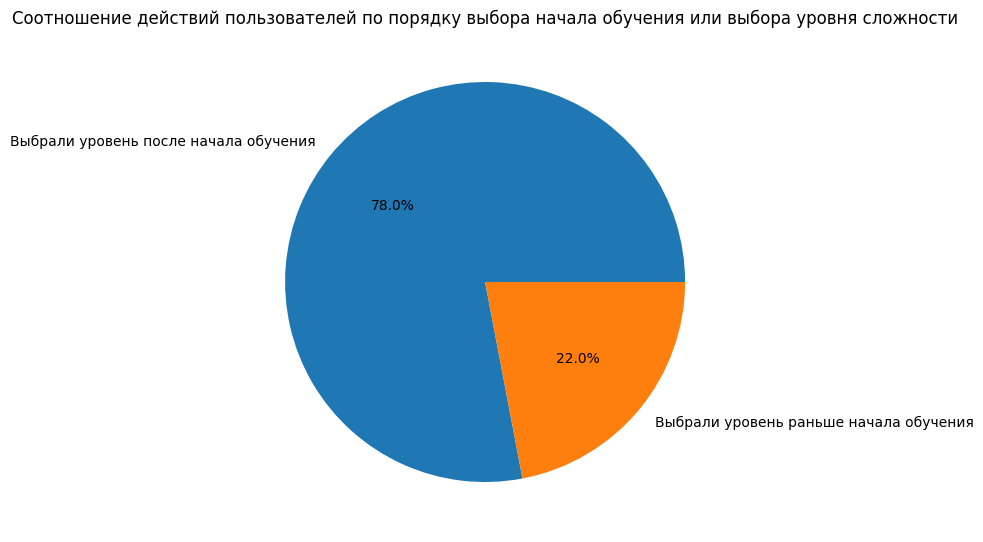

In [32]:
# группируем пользователей по порядку выбора первым уровня сложности и старта обучения
level_choise_table = time_of_two_events.level_choice_before.value_counts()
#визуализация графика
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
# визуализация графика о соотношении общей выручки с разных групп пользователей
axes.pie(
    x = level_choise_table,
    labels = level_choise_table.index,
    autopct='%.1f%%',
    pctdistance = 0.6
)
axes.set_title('Соотношение действий пользователей по порядку выбора начала обучения или выбора уровня сложности', fontsize = 12);


## Вывод:
Гипотеза №3 верна, если пользователь сначала выбирает сложность обучения, то обучение он после этого чаще всего не проходит. 
Процесс взаимодействия с игрой достаточно прозрачен, так как только в 20% случаев пользователи возвращаются к обучению после того, как уже выбрали уровень сложности. 17% уникальных пользователей возвращается к обучению после того, как уже выбрало уровень сложности.